In [1]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import random
from google.colab.patches import cv_imshow
import matplotlib.pyplot as plt

In [20]:
N=4000
H,W=256,256
train_img=np.zeros([N,H,W,3],dtype=np.uint8)
train_img.fill(255)
train_label_coord=np.zeros([N,2],dtype=np.int32)
train_label_size=np.zeros([N,2],dtype=np.int32)
train_label_class=np.zeros([N,1],dtype=np.int32)


In [21]:
for n in range(N):
  x,y = random.randint(0,W-1), random.randint(0,H-1)
  bw,bh = random.randint(int(W/16),int(W/4)),random.randint(int(H/16),int(H/4))

  if(x-bw/2<0):
    x= x-(x-bw/2)
  elif(x+bw/2>W-1):
    x= x-(x+bw/2-(W-1))
  if(y-bh/2<0):
    y= y-(y-bh/2)
  elif(y+bh/2>H-1):
    y= y-(y+bh/2-(H-1))

  x= int(x); y= int(y)
  train_label_coord[n,0]=x; train_label_coord[n,1]=y
  train_label_size[n,0]=bw; train_label_size[n,1]=bh
  train_label_class[n]= random.randint(0,3)

  if train_label_class[n] == 0: #red
    cv.rectangle(train_img[n], (x-int(bw/2), y-int(bh/2)),(x+int(bw/2), y+int(bh/2)), color=(0,0,255), thickness = -1)
  elif train_label_class[n] == 1: #green
    cv.rectangle(train_img[n], (x-int(bw/2), y-int(bh/2)),(x+int(bw/2), y+int(bh/2)), color=(0,255,0), thickness = -1)
  elif train_label_class[n] == 2: #blue
    cv.rectangle(train_img[n], (x-int(bw/2), y-int(bh/2)),(x+int(bw/2), y+int(bh/2)), color=(255,0,0), thickness = -1)
  else: #yellow
    cv.rectangle(train_img[n], (x-int(bw/2), y-int(bh/2)),(x+int(bw/2), y+int(bh/2)), color=(0,255,255), thickness = -1)

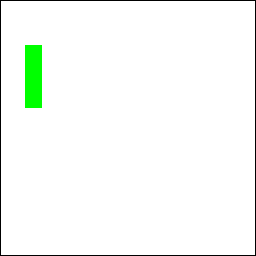

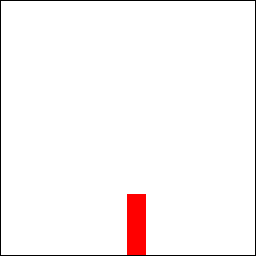

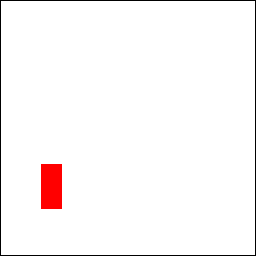

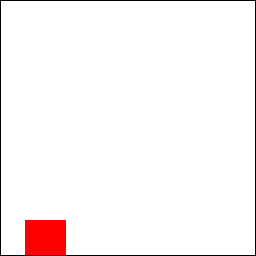

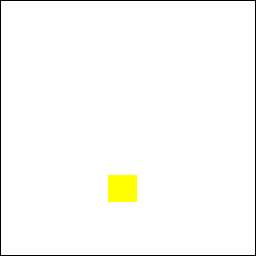

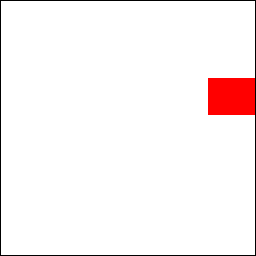

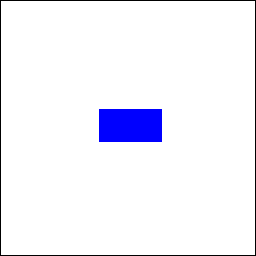

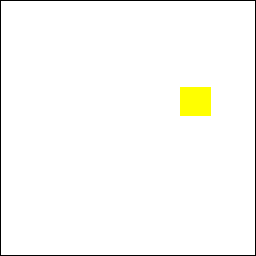

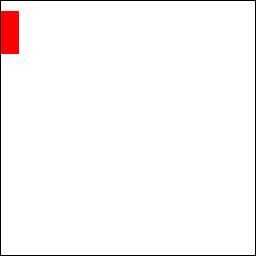

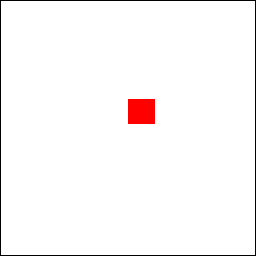

In [22]:
for n in range(10):
  cv_imshow(cv.rectangle(train_img[n], (0,0),(W-1,H-1),color = (0,0,0), thickness=1))
  #cv_imshow(train_img[n])

In [5]:
#Preprocessing
train_img = tf.keras.applications.vgg16.preprocess_input(train_img)

train_label_coord = train_label_coord.astype(np.float32)
train_label_coord[:,0]= train_label_coord[:,0]/W
train_label_coord[:,1]= train_label_coord[:,1]/H
train_label_size = train_label_size.astype(np.float32)
train_label_size[:,0]=train_label_size[:,0]/(W/4)
train_label_size[:,1]=train_label_size[:,1]/(H/4)

base_model =tf.keras.applications.VGG16(input_shape=[H,W,3], include_top=False, weights = 'imagenet')
x = base_model.output
x = tf.keras.layers.Flatten()(x)
out_coord = tf.keras.layers.Dense(2,activation ='sigmoid', name ='out_coord')(x)
out_size = tf.keras.layers.Dense(2,activation ='sigmoid', name ='out_size')(x)
out_class = tf.keras.layers.Dense(4,activation ='softmax', name ='out_class')(x)
model = tf.keras.Model(inputs = base_model.input, outputs = [out_coord, out_size, out_class])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [6]:
def coord_loss_func(y_true, y_pred):
  loss_coord = tf.keras.losses.mean_squared_error(y_true, y_pred)
  return loss_coord

def size_loss_func(y_true, y_pred):
  loss_size = tf.keras.losses.mean_squared_error(y_true, y_pred)
  return loss_size

def class_loss_func(y_true, y_pred):
  loss_class=tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
  return loss_class

In [7]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = {'out_coord': coord_loss_func, 'out_size': size_loss_func, 'out_class': class_loss_func},
              loss_weights = {'out_coord':4, 'out_size': 1, 'out_class':1})
history = model.fit(x=train_img,
                    y={'out_coord': train_label_coord, 'out_size': train_label_size, 'out_class': train_label_class},
                    epochs = 20, batch_size = 50, validation_split = 0.25)
model.save('model')

Epoch 1/20
60/60 [==============================] - 76s 1s/step - loss: 1.2255 - out_coord_loss: 0.0503 - out_size_loss: 0.0785 - out_class_loss: 0.9456 - val_loss: 0.2250 - val_out_coord_loss: 0.0269 - val_out_size_loss: 0.0865 - val_out_class_loss: 0.0308
Epoch 2/20
60/60 [==============================] - 57s 945ms/step - loss: 0.1238 - out_coord_loss: 0.0136 - out_size_loss: 0.0531 - out_class_loss: 0.0163 - val_loss: 0.0670 - val_out_coord_loss: 0.0061 - val_out_size_loss: 0.0360 - val_out_class_loss: 0.0065
Epoch 3/20
60/60 [==============================] - 57s 956ms/step - loss: 0.0391 - out_coord_loss: 0.0038 - out_size_loss: 0.0216 - out_class_loss: 0.0025 - val_loss: 0.0293 - val_out_coord_loss: 0.0029 - val_out_size_loss: 0.0149 - val_out_class_loss: 0.0027
Epoch 4/20
60/60 [==============================] - 62s 1s/step - loss: 0.0188 - out_coord_loss: 0.0021 - out_size_loss: 0.0092 - out_class_loss: 0.0013 - val_loss: 0.0150 - val_out_coord_loss: 0.0017 - val_out_size_loss

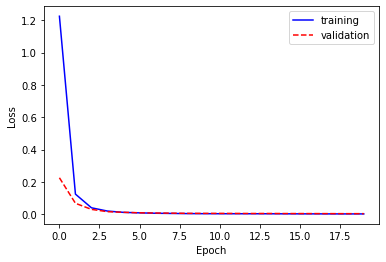

In [8]:
plt.figure()
plt.plot(history.history['loss'], 'b-'
, label='training')
plt.plot(history.history['val_loss'], 'r--'
, label='validation')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()
plt.show()

# Evaluating model

In [9]:
N=20
H,W=256,256
test_img=np.zeros([N,H,W,3],dtype=np.uint8)
test_img.fill(255)
test_label_coord=np.zeros([N,2],dtype=np.int32)
test_label_size=np.zeros([N,2],dtype=np.int32)
test_label_class=np.zeros([N,1],dtype=np.int32)

In [10]:
for n in range(N):
  x,y = random.randint(0,W-1), random.randint(0,H-1)
  bw,bh = random.randint(int(W/16), int(W/4)), random.randint(int(H/16), int(H/4))

  if(x-bw/2<0):
    x= x-(x-bw/2)
  elif(x+bw/2>W-1):
    x= x-(x+bw/2-(W-1))
  if(y-bh/2<0):
    y= y-(y-bh/2)
  elif(y+bh/2>H-1):
    y= y-(y+bh/2-(H-1))

  x= int(x); y= int(y)
  test_label_coord[n,0]=x; test_label_coord[n,1]=y
  test_label_size[n,0]=bw; test_label_size[n,1]=bh
  test_label_class[n]= random.randint(0,3)

  if test_label_class[n] == 0: #red
    cv.rectangle(test_img[n], (x-int(bw/2), y-int(bh/2)),(x+int(bw/2), y+int(bh/2)), color=(0,0,255), thickness = -1)
  elif test_label_class[n] == 1: #green
    cv.rectangle(test_img[n], (x-int(bw/2), y-int(bh/2)),(x+int(bw/2), y+int(bh/2)), color=(0,255,0), thickness = -1)
  elif test_label_class[n] == 2: #blue
    cv.rectangle(test_img[n], (x-int(bw/2), y-int(bh/2)),(x+int(bw/2), y+int(bh/2)), color=(255,0,0), thickness = -1)
  else: #yellow
    cv.rectangle(test_img[n], (x-int(bw/2), y-int(bh/2)),(x+int(bw/2), y+int(bh/2)), color=(0,255,255), thickness = -1)

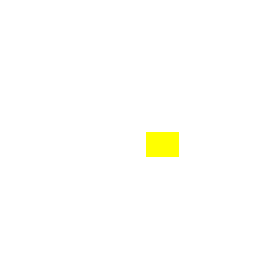

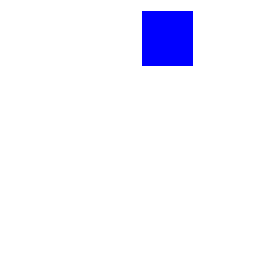

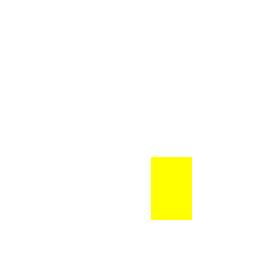

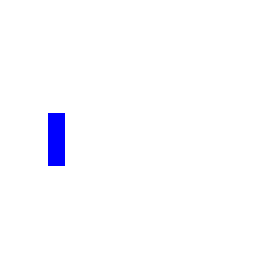

In [11]:
for n in range(4):
  #cv_imshow(cv.rectangle(test_img[n], (0,0), (W-1, H-1), color = (0,0,0),thickness = 1))
  cv_imshow(test_img[n])

In [12]:
test_img_ = tf.keras.applications.vgg16.preprocess_input(test_img)
test_label_coord = test_label_coord.astype(np.float32)
test_label_coord[:,0]= test_label_coord[:,0]/W
test_label_coord[:,1]= test_label_coord[:,1]/H
test_label_size = test_label_size.astype(np.float32)
test_label_size[:,0]=test_label_size[:,0]/(W/4)
test_label_size[:,1]=test_label_size[:,1]/(H/4)

model=tf.keras.models.load_model('model',
                                 custom_objects = {'coord_loss_func': coord_loss_func,
                                                   'size_loss_func': size_loss_func,
                                                   'class_loss_func': class_loss_func})
pred_coord,pred_size,pred_class=model.predict(test_img_)
pred_coord[:,0]=pred_coord[:,0]*W
pred_coord[:,1]=pred_coord[:,1]*H
pred_size[:,0]=pred_size[:,0]*(W/4)
pred_size[:,1]=pred_size[:,1]*(H/4)
pred_class=np.argmax(pred_class,axis=1)

161 147 32 25


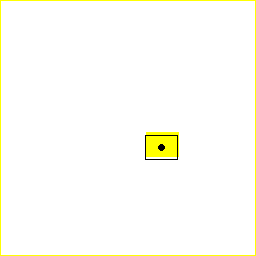

170 38 51 55


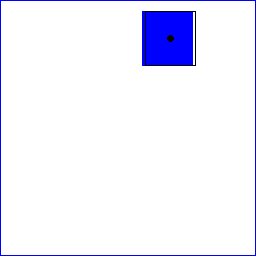

168 187 38 60


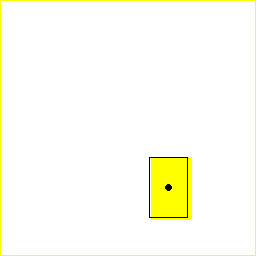

54 134 18 49


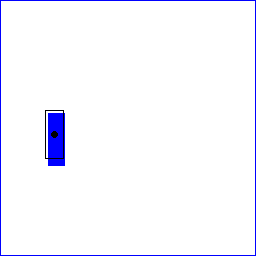

137 185 41 49


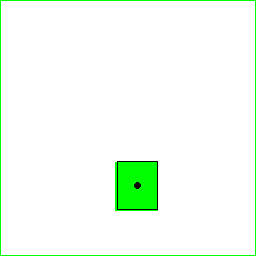

95 178 59 22


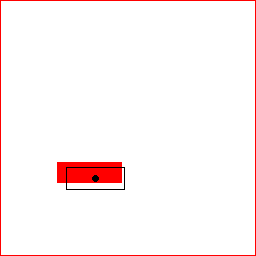

56 72 58 27


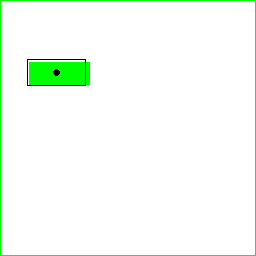

70 87 21 19


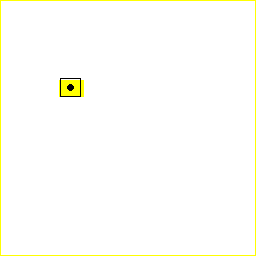

56 123 51 56


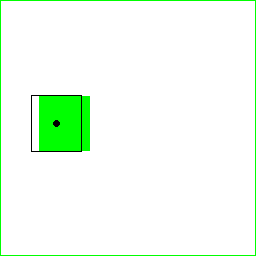

222 244 44 23


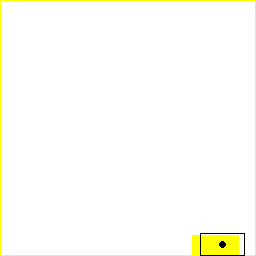

144 236 57 47


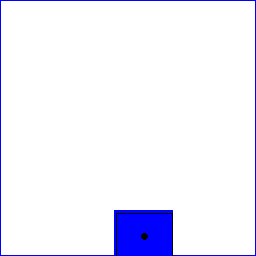

52 132 31 42


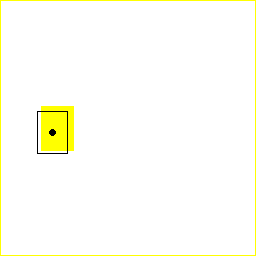

140 230 37 21


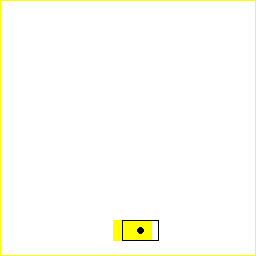

108 102 15 49


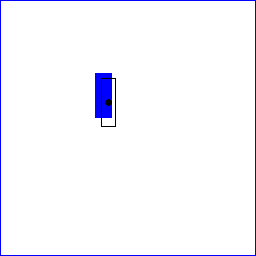

117 81 23 22


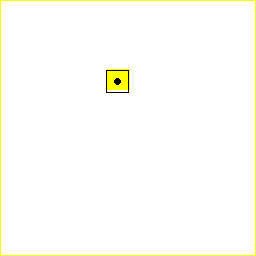

71 102 41 17


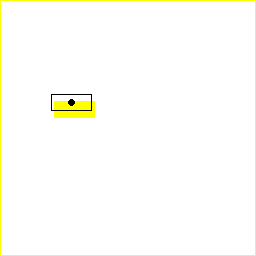

27 21 51 25


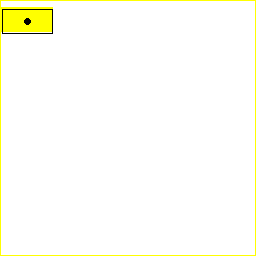

64 197 59 59


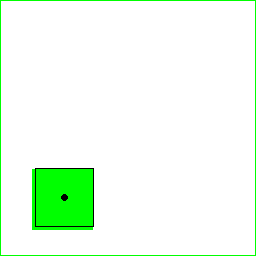

239 237 14 32


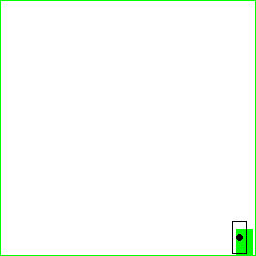

33 117 33 29


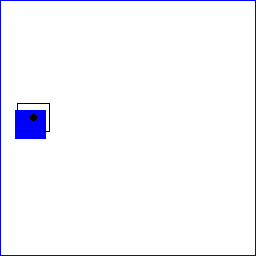

In [13]:
for n in range(N):
  x=pred_coord[n,0].astype('int')
  y=pred_coord[n,1].astype('int')
  bw=pred_size[n,0].astype('int')
  bh=pred_size[n,1].astype('int')
  color_class=pred_class[n]
  print(x,y, bw,bh)
  if color_class==0:
    cv.rectangle(test_img[n], (0,0),(W-1,H-1),color = (0,0,255), thickness=1)
  elif color_class==1: 
    cv.rectangle(test_img[n], (0,0),(W-1,H-1),color = (0,255,0), thickness=1)
  elif color_class==2: 
    cv.rectangle(test_img[n], (0,0),(W-1,H-1),color = (255,0,0), thickness=1)
  else:
    cv.rectangle(test_img[n], (0,0),(W-1,H-1),color = (0,255,255), thickness=1)
  cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),
               color=(0,0,0),thickness=1)
  cv.circle(test_img[n],center=(x,y),radius=2,color=(0,0,0),thickness=2)
  cv_imshow(test_img[n])